In [3]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.cluster import KMeans
from skimage import measure
import matplotlib.pyplot as plt
import pydot
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [4]:
import tensorflow as tf
import numpy as np
print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)

TensorFlow version: 2.16.1
NumPy version: 1.26.4


In [5]:
trainX = np.load(r"E:\ENGINEERING PROJECTS\MINI1\VAMSI\Unet\trainX.npy").astype(np.float32)
trainY = np.load(r"E:\ENGINEERING PROJECTS\MINI1\VAMSI\Unet\trainY.npy").astype(np.float32)
testX = np.load(r"E:\ENGINEERING PROJECTS\MINI1\VAMSI\Unet\testX.npy").astype(np.float32)
testY = np.load(r"E:\ENGINEERING PROJECTS\MINI1\VAMSI\Unet\testY.npy").astype(np.float32)

In [6]:
print(trainX.shape)
testX.shape

(180, 512, 512)


(46, 512, 512)

In [7]:
trainX = (trainX-127.0)/127.0
testX = (testX-127.0)/127.0
trainY = (trainY>127).astype(np.float32)
testY = (testY>127).astype(np.float32)

In [8]:
print(trainX.dtype)
print(trainY.dtype)
print(testX.dtype)
print(testY.dtype)

float32
float32
float32
float32


In [9]:
trainX = np.reshape(trainX, (len(trainX), 512, 512, 1))
trainY = np.reshape(trainY, (len(trainY), 512, 512, 1))
testX = np.reshape(testX, (len(testX), 512, 512, 1))
testY = np.reshape(testY, (len(testY), 512, 512, 1))

print("trainX:",trainX.shape)
print("trainY:",trainY.shape)
print("testX:",testX.shape)
print("testY:",testY.shape)

trainX: (180, 512, 512, 1)
trainY: (180, 512, 512, 1)
testX: (46, 512, 512, 1)
testY: (46, 512, 512, 1)


In [10]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [11]:
def unet(input_size=(512,512,1)):
    inputs = Input(input_size)
    K.set_image_data_format('channels_last')

    #Encoder
    conv1 = Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    conv1 = Conv2D(32, (3,3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(64, (3,3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(64, (3,3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(128, (3,3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(128, (3,3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = Conv2D(256, (3,3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(256, (3,3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)

    #BottleNeck
    conv5 = Conv2D(512, (3,3), activation="relu", padding="same")(pool4)
    conv5 = Conv2D(512, (3,3), activation="relu", padding="same")(conv5)

    #Decoder
    up6 = concatenate([Conv2DTranspose(256, kernel_size=(2,2), strides=(2,2), padding="same")(conv5), conv4], axis=-1)
    conv6 = Conv2D(256, (3,3), activation="relu", padding="same")(up6)
    conv6 = Conv2D(256, (3,3), activation="relu", padding="same")(conv6)

    up7 = concatenate([Conv2DTranspose(128, kernel_size=(2,2), strides=(2,2), padding="same")(conv6), conv3], axis=-1)
    conv7 = Conv2D(128, (3,3), activation="relu", padding="same")(up7)
    conv7 = Conv2D(128, (3,3), activation="relu", padding="same")(conv7)

    up8 = concatenate([Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2), padding="same")(conv7), conv2], axis=-1)
    conv8 = Conv2D(64, (3,3), activation="relu", padding="same")(up8)
    conv8 = Conv2D(64, (3,3), activation="relu", padding="same")(conv8)

    up9 = concatenate([Conv2DTranspose(32, kernel_size=(2,2), strides=(2,2), padding="same")(conv8), conv1], axis=-1)
    conv9 = Conv2D(32, (3,3), activation="relu", padding="same")(up9)
    conv9 = Conv2D(32, (3,3), activation="relu", padding="same")(conv9)

    conv10 = Conv2D(1, (1,1), activation="sigmoid")(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [12]:
model = unet(input_size=(512, 512, 1))
model.compile(optimizer=Adam(learning_rate=2e-4),
              loss=[dice_coef_loss],
              metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 512, 512, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 512, 512, 32)      │             320 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 512, 512, 32)      │           9,248 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 256, 256, 32)      │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 256, 256, 64)      │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 256, 256, 64)      │          36,928 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 128, 128, 64)      │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 128, 128, 128)     │          73,856 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 128, 128, 128)     │         147,584 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 64, 64, 128)       │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 64, 64, 256)       │         295,168 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 64, 64, 256)       │         590,080 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 32, 32, 256)       │               0 │ conv2d_7[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 32, 32, 512)       │       1,180,160 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 32, 32, 512)       │       2,359,808 │ conv2d_8[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose              │ (None, 64, 64, 256)       │         524,54

 Total params: 7,759,521 (29.60 MB)

 Trainable params: 7,759,521 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
weight_path = r"E:\ENGINEERING PROJECTS\MINI1\VAMSI\Unet\Weights\checkpoint-{epoch:03d}-{val_dice_coef:.3f}.keras"  # Change the filepath extension to .keras

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min')

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.7,
                                   patience=2,
                                   verbose=1, mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=18)

CALLBACKS = [checkpoint, early, reduceLROnPlat]


history = model.fit(x = trainX,
                    y = trainY,
                    batch_size = 3,
                    epochs = 10,
                    validation_data =(testX,testY),
                    callbacks=CALLBACKS
                  )

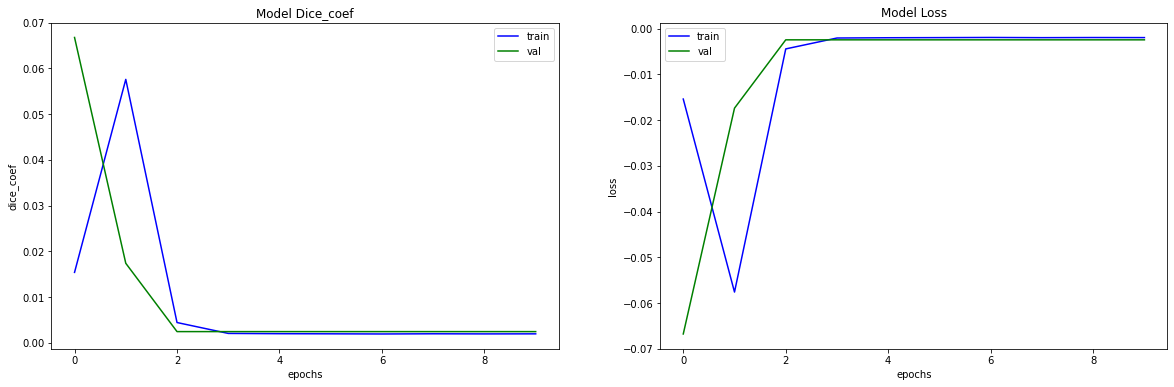

In [14]:
plt.figure(figsize=(20,6))
for i, met in enumerate(['dice_coef', 'loss']):
  plt.subplot(1,2,i+1)
  plt.plot(history.history[met], color="b")
  plt.plot(history.history["val_"+met], color="g")
  plt.title('Model '+met.capitalize())
  plt.xlabel('epochs')
  plt.ylabel(met)
  plt.legend(['train', 'val'])

In [15]:
import pickle
with open('LC_UNet_trainHistory', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [16]:
model.save("UNet.h5")

In [17]:
model.evaluate(testX, testY)

2/2 ━━━━━━━━━━━━━━━━━━━━ 67s 24s/step - binary_accuracy: 0.9992 - dice_coef: 2.2049e-04 - loss: -2.2049e-04


[-0.00026356364833191037, 0.999171793460846, 0.00026356364833191037]

In [13]:
model2 = unet(input_size=(512,512,1))
model2.load_weights(r"E:\ENGINEERING PROJECTS\MINI1\VAMSI\Unet\checkpoint-010-0.577.keras")
model2.compile(optimizer=Adam(learning_rate=2e-4),
                loss=[dice_coef_loss],
                metrics = [dice_coef, 'binary_accuracy'])

In [14]:
model2.evaluate(testX, testY)

2/2 ━━━━━━━━━━━━━━━━━━━━ 67s 20s/step - binary_accuracy: 0.9995 - dice_coef: 0.6485 - loss: -0.6485


[-0.6122380495071411, 0.9994834661483765, 0.6122380495071411]

In [13]:
model2.save("UNet_best_Model_checkpoint.keras")

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define the output folder
output_folder = r"E:\ENGINEERING PROJECTS\MINI1\VAMSI\Unet\outputs"

for i in range(30, min(80, len(testX))):  # Adjust the loop range
    output_subfolder = os.path.join(output_folder, f"outputs_{i}")
    os.makedirs(output_subfolder, exist_ok=True)
    
    test = np.squeeze(testX)[i]
    testy = np.squeeze(testY[i])
    t_p = model2.predict(np.reshape(test, (1, 512, 512, 1)))
    
    plt.figure(figsize=(20, 300))
    plt.subplot(50, 3, 1)
    
    plt.imshow(np.squeeze(test), cmap="gray")
    plt.axis('off')  # Turn off axis
    plt.savefig(os.path.join(output_subfolder, f"input_{i}.jpg"), bbox_inches='tight', pad_inches=0)
    plt.close()

    plt.figure(figsize=(20, 300))
    plt.imshow(np.squeeze(t_p), cmap="gray")
    plt.axis('off')  # Turn off axis
    plt.savefig(os.path.join(output_subfolder, f"prediction_{i}.jpg"), bbox_inches='tight', pad_inches=0)
    plt.close()

    plt.figure(figsize=(20, 300))
    plt.imshow(np.squeeze(testy), cmap="gray")
    plt.axis('off')  # Turn off axis
    plt.savefig(os.path.join(output_subfolder, f"Ground-Truth_{i}.jpg"), bbox_inches='tight', pad_inches=0)
    plt.close()

    plt.figure(figsize=(20, 300))
    plt.imshow(cv2.addWeighted(np.squeeze(test), .5, np.squeeze(t_p), .5, 0), cmap="gray")
    plt.axis('off')  # Turn off axis
    plt.savefig(os.path.join(output_subfolder, f"overlay_{i}.jpg"), bbox_inches='tight', pad_inches=0)
    plt.close()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


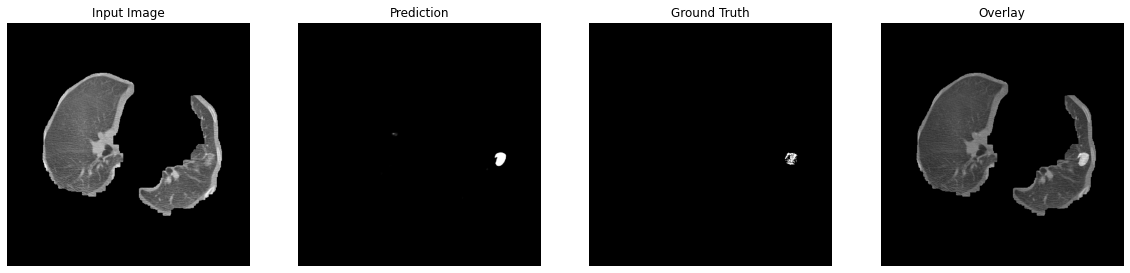

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


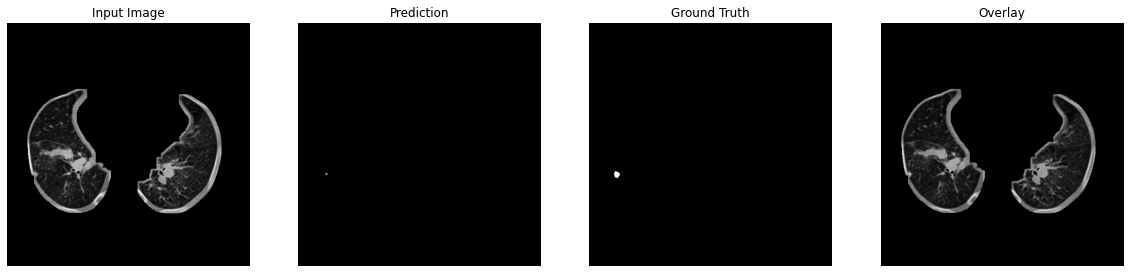

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


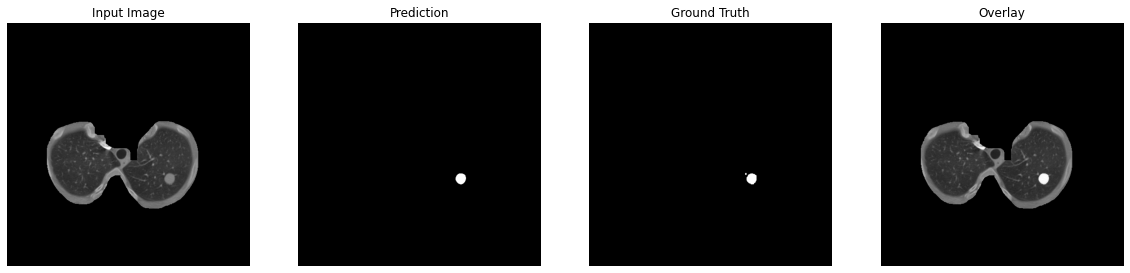

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


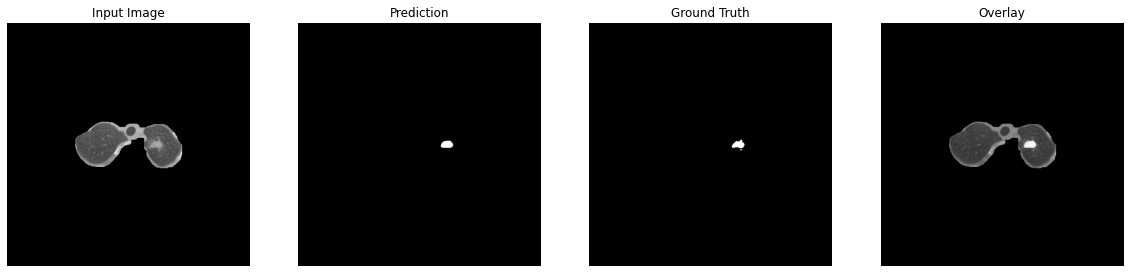

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


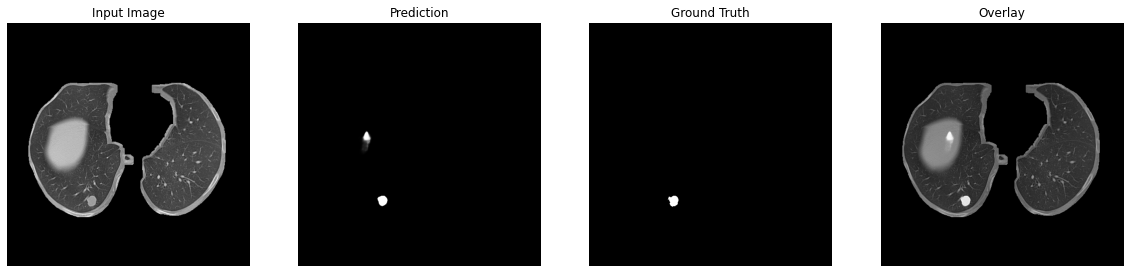

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


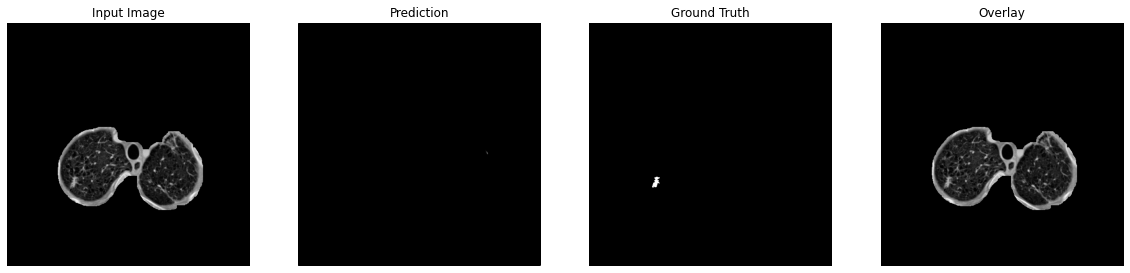

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


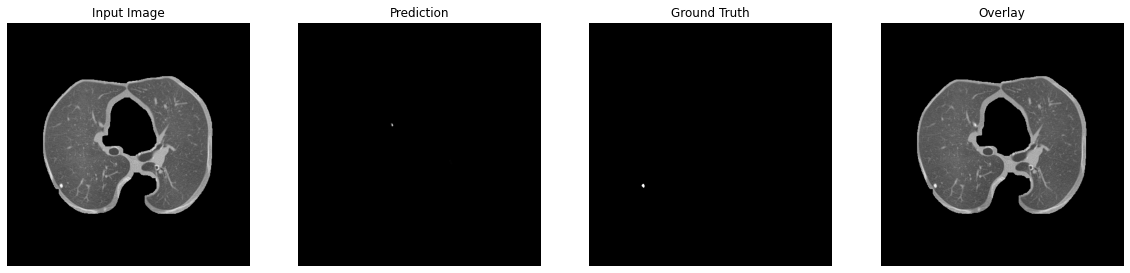

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


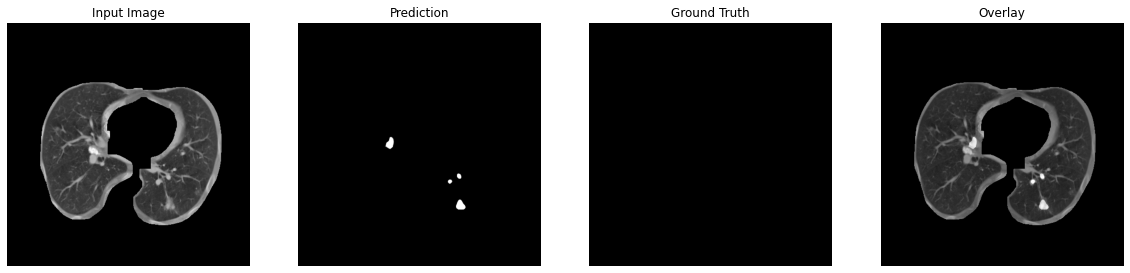

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


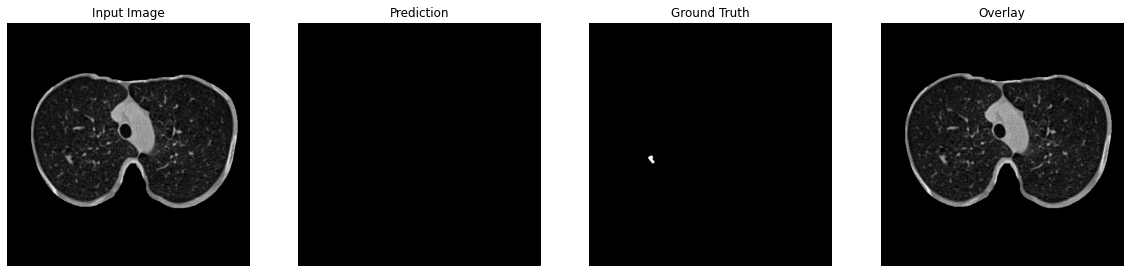

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


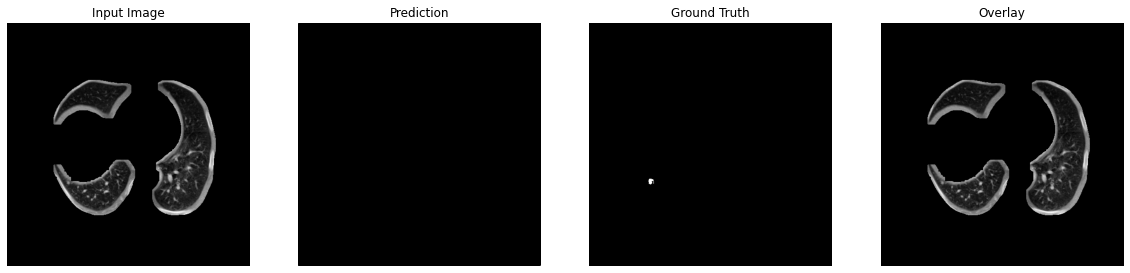

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


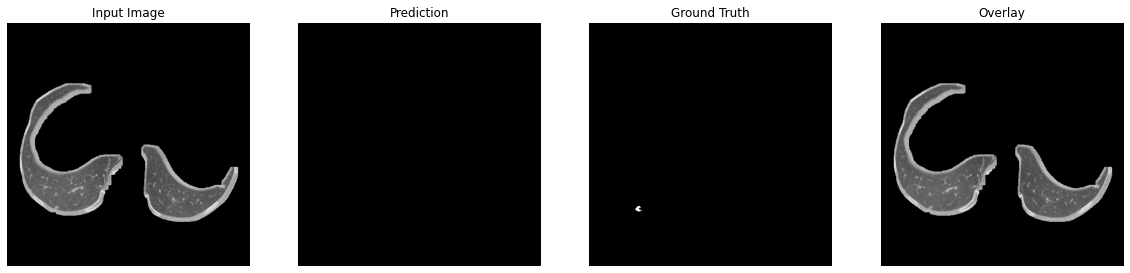

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


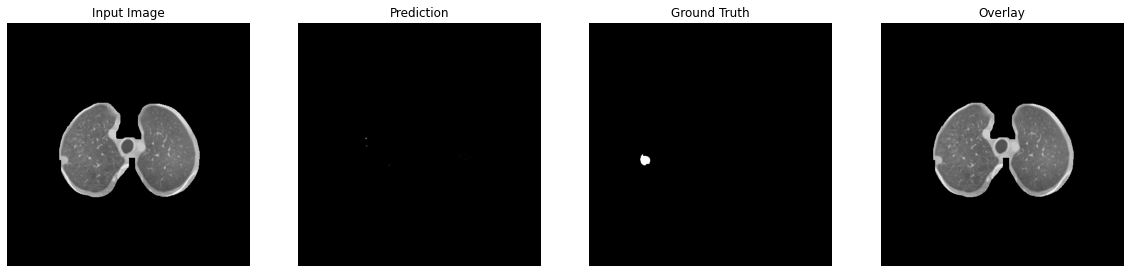

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


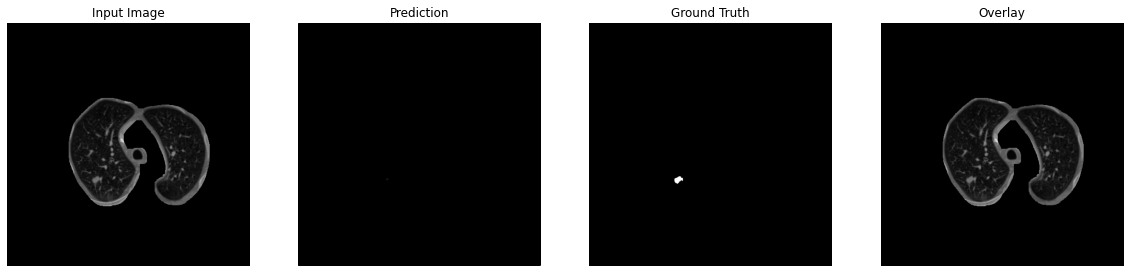

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


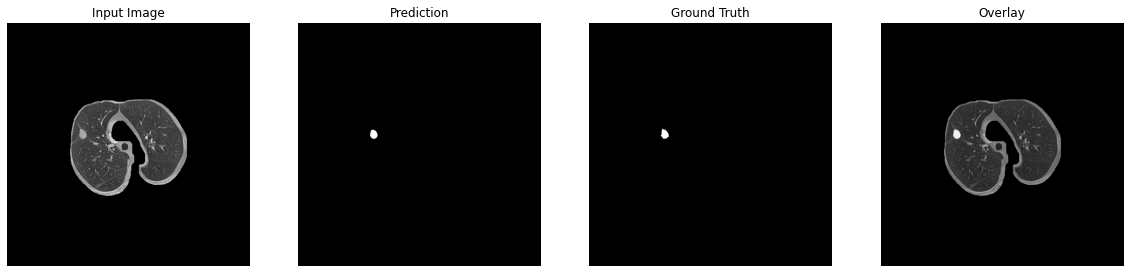

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


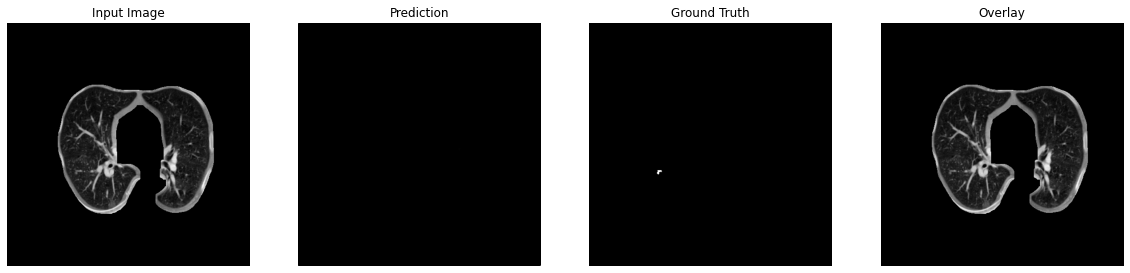

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


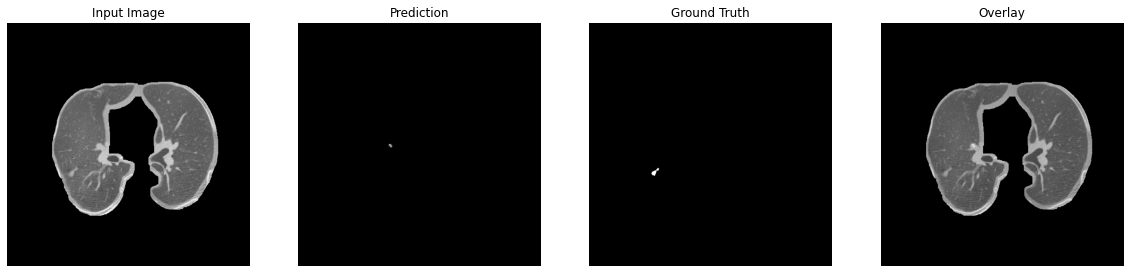

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Assuming testX is defined and model2 is already trained and loaded
for i in range(30, min(80, len(testX))):  # Adjust the loop range
    # Extract and predict
    output_subfolder = os.path.join(output_folder, f"outputs_{i}")
    os.makedirs(output_subfolder, exist_ok=True)
    
    
    test = np.squeeze(testX[i])  # Ensure correct indexing
    testy = np.squeeze(testY[i]) 
    t_p = model2.predict(np.reshape(test, (1, 512, 512, 1)))

    # Prepare overlay
    overlay = cv2.addWeighted(np.squeeze(test), 0.5, np.squeeze(t_p), 0.5, 0)

    # Plotting all three images side by side
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # Adjust figure size as needed

    # Display test image
    axes[0].imshow(test, cmap='gray')
    axes[0].axis('off')  # Turn off axis
    axes[0].set_title('Input Image')
    plt.savefig(os.path.join(output_subfolder, f"input_{i}.jpg"), bbox_inches='tight', pad_inches=0)
    # Display prediction image
    axes[1].imshow(np.squeeze(t_p), cmap='gray')
    axes[1].axis('off')
    axes[1].set_title('Prediction')
    
    # Display prediction image
    axes[2].imshow(testy, cmap='gray')
    axes[2].axis('off')
    axes[2].set_title('Ground Truth')

    # Display overlay image
    axes[3].imshow(overlay, cmap='gray')
    axes[3].axis('off')
    axes[3].set_title('Overlay')

    # Display the figure
    plt.show()
    plt.close(fig)  # Close the figure to free memory


In [23]:
threshold = 0.5
y_pred = (predictions > threshold).astype(int)
y_pred_flat = y_pred.flatten()
testY_flat = testY.flatten()